### Predict the groundwater PFAS concentration at a given pair of coordinates using KNearestNeighbors.

Using the wealth of groundwater data available in CA this tool will predict the concentration of a PFAS compound for a given set of coordinates using the KNearestNeighbors algorithm. 

This example is using PFOA

The concentration is represented by the following classes:<br>
**Class 0**: Not detected<br>
**Class 1**: >0 and <=5.1 ppt (the CA water board notification limit)<br>
**Class 2**: >5.1 and <=70 ppt<br>
**Class 3**: >70 ppt (the US EPA notification limit threshold)<br>

The idea for this tool is if you want to know what the groundwater PFOA level is at a well but you have no available data, can we get an accurate prediction of what the concentration would be? This could apply to your private drinkingwater well at your home and you want to know if it is safe to drink (Class 1 or 0 according to regulatory levels).


First lets import all the libraries we will be using:

In [1]:
import numpy as np
from math import radians
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from numpy import mean, sqrt, square, arange
import numpy as np
from sklearn.metrics import mean_squared_error 
from sklearn import preprocessing
import seaborn as sns
terrain = sns.color_palette(palette='terrain',n_colors=10)
plasma = sns.color_palette(palette='plasma',n_colors=10)
rainbow = sns.color_palette(palette='rainbow',n_colors=6)
%matplotlib inline

from bokeh.io import output_notebook
from bokeh.layouts import gridplot,row,column
from bokeh.plotting import figure,show
output_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Loading BokehJS ...

Next, lets get our california groundwater PFAS data set. This was exported from my database as a CSV and contains all PFOA data for wells in CA.

In [2]:
import pandas as pd
pfas_well_df = pd.read_csv("PFOA_wells_CA.csv")
pfas_well_df.head()

,Regional Board,Site Name,Global ID,Location ID,Sample ID,Matrix,Chemical,Detected_Value,All_values,Qualifier,...,Units,Date,Field Pt Class,Site Use,Site Type,Address,City,Latitude,Longitude,Class
0,CENTRAL VALLEY RWQCB (REGION 5S),Linda Cnty Water District WWTP,NPD100051617,PLT INF,Plant Influent,Gas,PFOA,2.0,2.0,=,...,NG/L,8/27/2021,IS,Wastewater Treatment Plants,* NPDES,909 Myrna Avenue,Marysville,39.101390,-121.583990,1
1,CENTRAL VALLEY RWQCB (REGION 5S),Linda Cnty Water District WWTP,NPD100051617,PLT EFF,Plant Effluent,Gas,PFOA,6.9,6.9,=,...,NG/L,8/27/2021,ES,Wastewater Treatment Plants,* NPDES,909 Myrna Avenue,Marysville,39.101390,-121.583990,2
2,CENTRAL COAST RWQCB (REGION 3),SAN LUIS COUNTY RGNL,T10000012768,GW-2,GW-GW-2,Solid,PFOA,6.2,6.2,=,...,NG/L,5/4/2020,AGIR,Airport,Cleanup Program Site,975 Airport Drive,San luis Obispo,35.238029,-120.649158,2
3,CENTRAL COAST RWQCB (REGION 3),SAN LUIS COUNTY RGNL,T10000012768,MW-2P,GW-MW-2-P,Solid,PFOA,0.0,1.8,ND,...,NG/L,5/5/2020,MW,Airport,Cleanup Program Site,975 Airport Drive,San luis Obispo,35.231070,-120.631918,0
4,CENTRAL COAST RWQCB (REGION 3),SAN LUIS COUNTY RGNL,T10000012768,MW-2,GW-MW-2,Solid,PFOA,0.0,1.8,ND,...,NG/L,5/5/2020,MW,Airport,Cleanup Program Site,975 Airport Drive,San luis Obispo,35.231086,-120.631969,0


In [3]:
#drop nulls
pfas_well_df = pfas_well_df.dropna()

Now we need to set up our training data sets and independent variables. There are several variables that can influence how chemicals move in the groundwater including:<br>
- soil lithology
- groundwater depth
- groundwater flow velocity
- groundwater flow direction<br>
<br>
For now we are going to keep it simple and use coordinates or proximity. i.e. if nearby wells are of a specific class, it is likely that the coordinates belong to the same class (nearest neighbor).


In [5]:
#X = pfas_well_df[['Latitude', 'Longitude']].values
X = pd.concat([pfas_well_df['Latitude'], pfas_well_df['Longitude']],axis=1)
y = pfas_well_df['Class']
X

,Latitude,Longitude
11,35.239060,-120.638060
34,36.517963,-119.587906
35,36.517963,-119.587906
36,38.883523,-121.107111
38,40.162944,-122.221228
...,...,...
4833,34.236390,-119.258610
4839,38.983570,-122.627050
4841,34.236390,-119.258610
4859,34.462431,-118.585804


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)

In [7]:
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (926, 2) (926,)
Test set: (232, 2) (232,)


In [8]:
#generate figure of locations
p = figure(title="Well Classification",y_range=(32.5,42.0),x_range=(-124.4,-114.2))
p.xaxis.axis_label = 'longitude'
p.yaxis.axis_label = 'latitude'
zero_Lat=pfas_well_df['Latitude'][pfas_well_df['Class']==0]
zero_Long=pfas_well_df['Longitude'][pfas_well_df['Class']==0]
one_Lat=pfas_well_df['Latitude'][pfas_well_df['Class']==1]
one_Long=pfas_well_df['Longitude'][pfas_well_df['Class']==1]
two_Lat=pfas_well_df['Latitude'][pfas_well_df['Class']==2]
two_Long=pfas_well_df['Longitude'][pfas_well_df['Class']==2]
three_Lat=pfas_well_df['Latitude'][pfas_well_df['Class']==3]
three_Long=pfas_well_df['Longitude'][pfas_well_df['Class']==3]
p.circle(zero_Long,zero_Lat,size=3,color=terrain.as_hex()[1],fill_alpha=0.5,line_alpha=0.5,legend_label='Class 0')
p.circle(one_Long,one_Lat,size=3,color=terrain.as_hex()[3],fill_alpha=0.5,line_alpha=0.5,legend_label='Class 1')
p.circle(two_Long,two_Lat,size=3,color=plasma.as_hex()[9],fill_alpha=0.5,line_alpha=0.5,legend_label='Class 2')
p.circle(three_Long,three_Lat,size=3,color=plasma.as_hex()[5],fill_alpha=0.5,line_alpha=0.5,legend_label='Class 3')
show(p, notebook_handle=True)

Here we can see a graph of the distributions of all our data by class.

In [9]:
#generate figures of locations broken by class
p0 = figure(width=500, height=500, title=None,y_range=(32.5,42.0),x_range=(-124.4,-114.2))
p0.circle(zero_Long,zero_Lat,size=3,color=terrain.as_hex()[1],fill_alpha=0.5,line_alpha=0.5,legend='Class 0')
p1 = figure(width=500, height=500, title=None,y_range=(32.5,42.0),x_range=(-124.4,-114.2))
p1.circle(one_Long,one_Lat,size=3,color=terrain.as_hex()[3],fill_alpha=0.5,line_alpha=0.5,legend='Class 1')
p2 = figure(width=500, height=500, title=None,y_range=(32.5,42.0),x_range=(-124.4,-114.2))
p2.circle(two_Long,two_Lat,size=3,color=plasma.as_hex()[9],fill_alpha=0.5,line_alpha=0.5,legend='Class 2')
p3 = figure(width=500, height=500, title=None,y_range=(32.5,42.0),x_range=(-124.4,-114.2))
p3.circle(three_Long,three_Lat,size=3,color=plasma.as_hex()[5],fill_alpha=0.5,line_alpha=0.5,legend='Class 3')
show(column(p0,p1,p2,p3), notebook_handle=True)

Here is the graph broken out into individual classes

In [10]:
from sklearn.neighbors import KNeighborsClassifier


model = KNeighborsClassifier(n_neighbors=9)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mat=[y_pred,y_test]

df=pd.DataFrame(mat).transpose()
df.columns=('h0','y')
df['diff']=np.where(df.h0==df.y,1,0)
print('% correct =',sum(df['diff'])/len(df['diff'])*100)


% correct = 68.53448275862068


Here we can see that when we compare our predicted data set against the training data set we have 68.5% of the values being correct.

Next we want to check log loss which is an important metric of model performance and is more insightful than just accuracy:

In [18]:
#check log loss
PredProb=model.predict_proba(X_test)
pred=np.asmatrix(PredProb)
pred.columns=('0','1','2','3')
s=np.asmatrix(pd.get_dummies(y_test))
def f(x):
    return sp.log(sp.maximum(sp.minimum(x,1-10**-5),10**-5))
f=np.vectorize(f)
predf=f(pred)
mult=np.multiply(predf,s)
print('log loss =',np.sum(mult)/-len(y_test))



log loss = 0.9816520215673028


Here we can see the log loss is fairly high indicating poor performance by the model

Next we will try to find the optimal K value to try and improve performance. The K value being the number of neighbors to consider.

In [19]:
#loop to optomize K
accuracy_big=[]
logloss_big=[]
def f(x):
    return sp.log(sp.maximum(sp.minimum(x,1-10**-5),10**-5))
f=np.vectorize(f)

for j in range (3,20,2): #j in range of odd numbers between 3 and 20
    logloss=[]  #empty array
    accuracy=[] #empty array
    for i in range (5): #iterations of random states
        #split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        model = KNeighborsClassifier(n_neighbors=j)
        #train classifier
        model.fit(X_train, y_train)
        
        #find % predicted correctly for this value of k (j)
        y_pred = model.predict(X_test)
        mat=[y_pred,y_test]
        df=pd.DataFrame(mat).transpose()
        df.columns=('h0','y')
        df['diff']=np.where(df.h0==df.y,1,0)
        accuracy.append(sum(df['diff'])/len(df['diff']))
        
        #find the logloss for this k
        y_pred=model.predict_proba(X_test)
        pred=np.asmatrix(PredProb)
        pred.columns=('0','1','2','3')
        s=np.asmatrix(pd.get_dummies(y_test))
        predf=f(pred)
        mult=np.multiply(predf,s)
        logloss.append(np.sum(mult)/-len(y_test)) #append array with logloss
    logloss_big.append(np.mean(logloss)) #take the average of the 5 random state runs and append the logloss for k values
    accuracy_big.append(np.mean(accuracy))
print(accuracy_big)
print(logloss_big)

[0.7155172413793103, 0.7137931034482758, 0.7258620689655173, 0.6931034482758621, 0.7068965517241379, 0.7017241379310345, 0.6801724137931034, 0.685344827586207, 0.675]
[2.567137168516858, 2.6341639803205648, 2.5461529051992646, 2.5718957096296116, 2.4726720479300974, 2.583336443182221, 2.4672189651060537, 2.5213299007608585, 2.585215812341051]


Text(0.5, 1.0, 'KNN logloss on longitude and latitude')

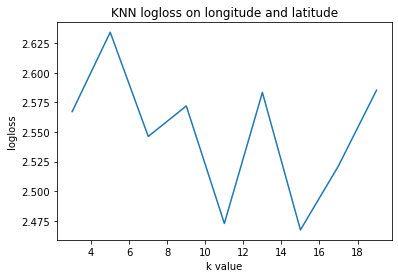

In [20]:
#see logloss change with k value
plt.plot(range(3,20,2),logloss_big)
plt.ylabel('logloss')
plt.xlabel('k value')
plt.title('KNN logloss on longitude and latitude')

Here we cant see a clear trend that changing the K value has on logloss

Text(0.5, 1.0, 'KNN prediction on longitude and latitude')

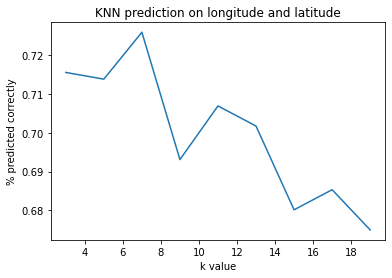

In [21]:
#see accuracy change with k value
plt.plot(range(3,20,2),accuracy_big)
plt.ylabel('% predicted correctly')
plt.xlabel('k value')
plt.title('KNN prediction on longitude and latitude')

If we look at the the effect K value has on the prediction accuracy, we see that as K increases, accuracy decreases. This is because including more neighbors for a set of coordinates means considering other groundwater wells that are further and further away and less likely to be representative of the coordinates you are looking at.<Br>
<br>
#### Below we can input coordinates into our model and it will return the class:

In [23]:
#predict a set of coordinates to return the class for PFOA
#Class 0: ND
#Class 1: 0 to 5.1 ppt
#Class 2: 5.1 to 70 ppt
#Class 3: >70 ppt
model.predict([[33.854,-117.92]])

array([2], dtype=int64)